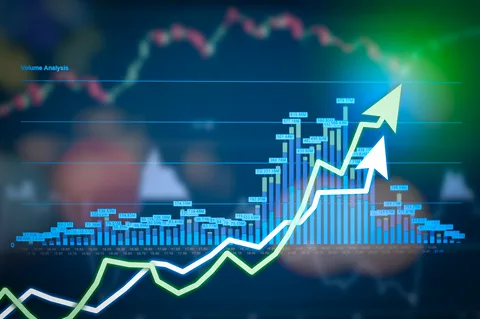

Basically, stock analysis means trying to figure out if a stock is worth buying or selling. There are two main ways to do this;

1. **Fundamental Analysis**
This is about the company behind the stock, and you look at how much money it makes how much it owes and how strong it is in the market. It helps you see if the stock is truly worth its price

2. **Technical Analysis**
This is about looking at the stock chart, and you check patterns price movements and how often people are buying or selling. The goal is to predict where the stock price might go next

In short, stock analysis helps you decide what to buy when to buy and when to sell.

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers.default = 'colab'

In [25]:
stock_ticker = 'AAPL'
comp_ticker = 'MSFT'
benchmark_ticker = '^GSPC'
end_date = datetime.now()
start_date = end_date - timedelta(days = 5 * 365)

try:
    stock_data = yf.download(stock_ticker, start = start_date, end = end_date, progress = False)
    comp_data = yf.download(comp_ticker, start = start_date, end = end_date, progress = False)
    benchmark_data = yf.download(benchmark_ticker, start = start_date, end = end_date, progress = False)

    if stock_data.empty or comp_data.empty or benchmark_data.empty: raise ValueError("Failed to fetch data.")

    print(f"{stock_ticker} Data Sample:")
    display(stock_data.head(10))

except Exception as e:
    print(f"Error: {e}")
    raise

AAPL Data Sample:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-07-20,95.610283,95.748805,93.379386,93.724474,90318000
2020-07-21,94.290718,96.477874,94.040411,96.402539,103433200
2020-07-22,94.555595,95.238473,93.904311,93.991794,89001600
2020-07-23,90.251755,94.366035,89.440078,94.288268,197004400
2020-07-24,90.028175,90.373263,86.655094,88.446138,185438800
2020-07-27,92.161865,92.254213,90.869019,91.092591,121214000
2020-07-28,90.647881,91.909141,90.643015,91.731736,103625600
2020-07-29,92.385429,92.570125,91.095009,91.131460,90329200


The code downloads historical stock price data for three tickers: Apple (AAPL), Microsoft (MSFT), and the S\&P 500 index (^GSPC) to use as a benchmark. Then, it sets the date range to the last five years by calculating the current date and subtracting five years worth of days. Additionally, it tries to get the data using the *yf.download* function from the yfinance library for each ticker within that date range. After downloading the data it checks if any of the data sets are empty which would mean the download failed for some reason. If all the data was fetched successfully it prints the first few rows of Apple’s stock data so you can see what it looks like. On the other hand, if there is any error during the process it catches the error prints an error message and stops the program.

Shortly, this code helps you automatically collect and verify historical stock data for a few important tickers to analyze or use in your projects.

In [26]:
# daily returns

stock_data['Daily Return'] = stock_data['Close'].pct_change()
comp_data['Daily Return'] = comp_data['Close'].pct_change()
benchmark_data['Daily Return'] = benchmark_data['Close'].pct_change()

# annualized metrics

trading_days = 252
stock_volatility = stock_data['Daily Return'].std() * np.sqrt(trading_days)
comp_volatility = comp_data['Daily Return'].std() * np.sqrt(trading_days)
benchmark_volatility = benchmark_data['Daily Return'].std() * np.sqrt(trading_days)

# sharpe Ratio

risk_free_rate = 0.02
stock_sharpe = (stock_data['Daily Return'].mean() * trading_days - risk_free_rate) / stock_volatility
comp_sharpe = (comp_data['Daily Return'].mean() * trading_days - risk_free_rate) / comp_volatility

# beta (covariance of stock returns with market returns / market variance)

cov_matrix = pd.concat([stock_data['Daily Return'], benchmark_data['Daily Return']], axis = 1).cov()
stock_beta = cov_matrix.iloc[0, 1] / benchmark_data['Daily Return'].var()

print(f"{stock_ticker} Annualized Volatility: {stock_volatility:.2%}")
print(f"{stock_ticker} Sharpe Ratio: {stock_sharpe:.2f}")
print(f"{stock_ticker} Beta: {stock_beta:.2f}")
print(f"{comp_ticker} Annualized Volatility: {comp_volatility:.2%}")
print(f"{comp_ticker} Sharpe Ratio: {comp_sharpe:.2f}")

AAPL Annualized Volatility: 29.83%
AAPL Sharpe Ratio: 0.61
AAPL Beta: 1.29
MSFT Annualized Volatility: 26.75%
MSFT Sharpe Ratio: 0.75


The code calculates key financial metrics to evaluate the performance and risk of 2 stocks compared to a benchmark index.

1. **Daily Returns Calculation**
   The daily returns for each asset—stock, competitor, and benchmark—are computed as the percentage change in their closing prices from one day to the next. This provides a time series of daily percentage gains or losses.

2. **Annualized Volatility**
   Volatility, a measure of risk or price variability, is calculated by taking the standard deviation of daily returns and then annualizing it by multiplying by the square root of the typical number of trading days in a year (252). This gives an estimate of how much the stock price fluctuates on an annual basis.

3. **Sharpe Ratio Calculation**
   The Sharpe Ratio is a risk-adjusted performance metric that measures the excess return (average return minus the risk-free rate) per unit of volatility. Here, the risk-free rate is assumed to be 2% annually. The ratio is calculated by subtracting the risk-free rate from the annualized average return and dividing the result by annualized volatility. A higher Sharpe Ratio indicates better risk-adjusted returns.

4. **Beta Calculation**
   Beta measures the stock’s sensitivity to market movements. It is computed as the covariance between the stock’s daily returns and the benchmark’s daily returns divided by the variance of the benchmark’s returns. A beta greater than 1 indicates higher volatility than the market, while less than 1 indicates lower volatility.

Eventually, the code prints the annualized volatility, Sharpe Ratio, and Beta for the primary stock, as well as the volatility and Sharpe Ratio for the competitor stock.

In [27]:
# Simple Moving Averages (SMA)

stock_data['SMA_50'] = stock_data['Close'].rolling(window = 50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window = 200).mean()

# Relative Strength Index (RSI)

def calculate_rsi(data, periods = 14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window = periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window = periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

stock_data['RSI'] = calculate_rsi(stock_data)

# MACD (12-day EMA - 26-day EMA, with 9-day signal line)

stock_data['EMA_12'] = stock_data['Close'].ewm(span = 12, adjust = False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span = 26, adjust = False).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span = 9, adjust = False).mean()

# Bollinger Bands (20-day SMA ± 2 standard deviations)

stock_data['BB_Middle'] = stock_data['Close'].rolling(window = 20).mean()
stock_data['BB_Std'] = stock_data['Close'].rolling(window = 20).std()
stock_data['BB_Upper'] = stock_data['BB_Middle'] + 2 * stock_data['BB_Std']
stock_data['BB_Lower'] = stock_data['BB_Middle'] - 2 * stock_data['BB_Std']

The code computes multiple widely used technical indicators to analyze the price movements and momentum of a stock.

1. **Simple Moving Averages (SMA)**:

The 50-day SMA and 200-day SMA are calculated by taking the rolling average of the closing prices over the past 50 and 200 days, respectively. These SMAs help identify trends and potential support or resistance levels in the stock price.

2. **Relative Strength Index (RSI)**:

The RSI is a momentum oscillator that measures the speed and change of price movements over a 14-day period by default. It is calculated by separating gains and losses, averaging them, and computing the ratio of average gain to average loss. The RSI value ranges between 0 and 100. Values above 70 typically indicate overbought conditions, while values below 30 suggest oversold conditions.

3. **Moving Average Convergence Divergence (MACD)**:

MACD is calculated as the difference between the 12-day and 26-day Exponential Moving Averages (EMA) of the closing price. A 9-day EMA of the MACD line *MACD_Signal* acts as a signal line to identify buy or sell signals when it crosses the MACD.

4. **Bollinger Bands**:

Bollinger Bands consist of three lines: a 20-day SMA, and upper and lower bands set two standard deviations above and below the SMA. These bands help visualize volatility and potential price reversals when the price touches or crosses the bands.

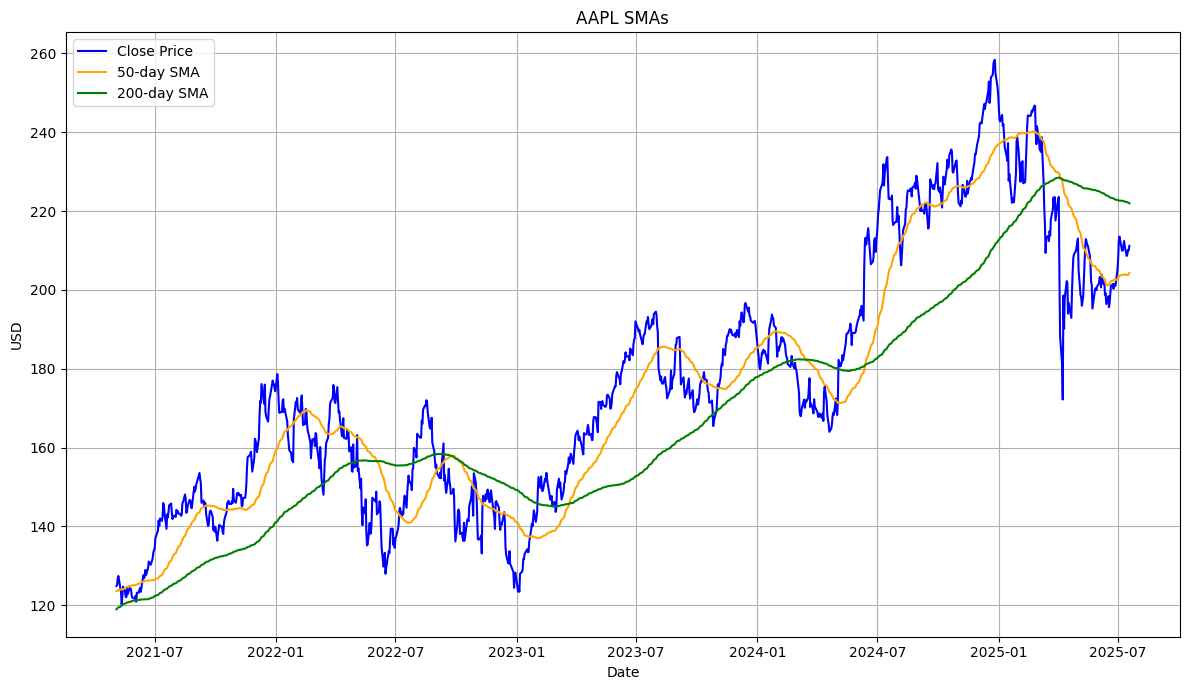

In [36]:
# Plot SMAs

# fig = go.Figure()
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['Close'], name = 'Close Price', line = dict(color = 'blue')))
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['SMA_50'], name = '50-day SMA', line = dict(color = 'orange')))
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['SMA_200'], name = '200-day SMA', line= dict(color = 'green')))
# fig.update_layout(title = f'{stock_ticker} SMAs', xaxis_title = 'Date', yaxis_title = '(USD)', template = 'plotly_white')
# fig.show()

plt.figure(figsize = (12, 7))
plt.plot(stock_data.index, stock_data['Close'], label = 'Close Price', color = 'blue')
plt.plot(stock_data.index, stock_data['SMA_50'], label = '50-day SMA', color = 'orange')
plt.plot(stock_data.index, stock_data['SMA_200'], label = '200-day SMA', color = 'green')

plt.title(f'{stock_ticker} SMAs')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* The 50-day SMA (orange line) smooths out short-term price changes.
* The 200-day SMA (green line) shows the long-term trend. By looking at these lines together, you can see if the stock is trending up or down and spot possible buy or sell signals when the price crosses these averages.

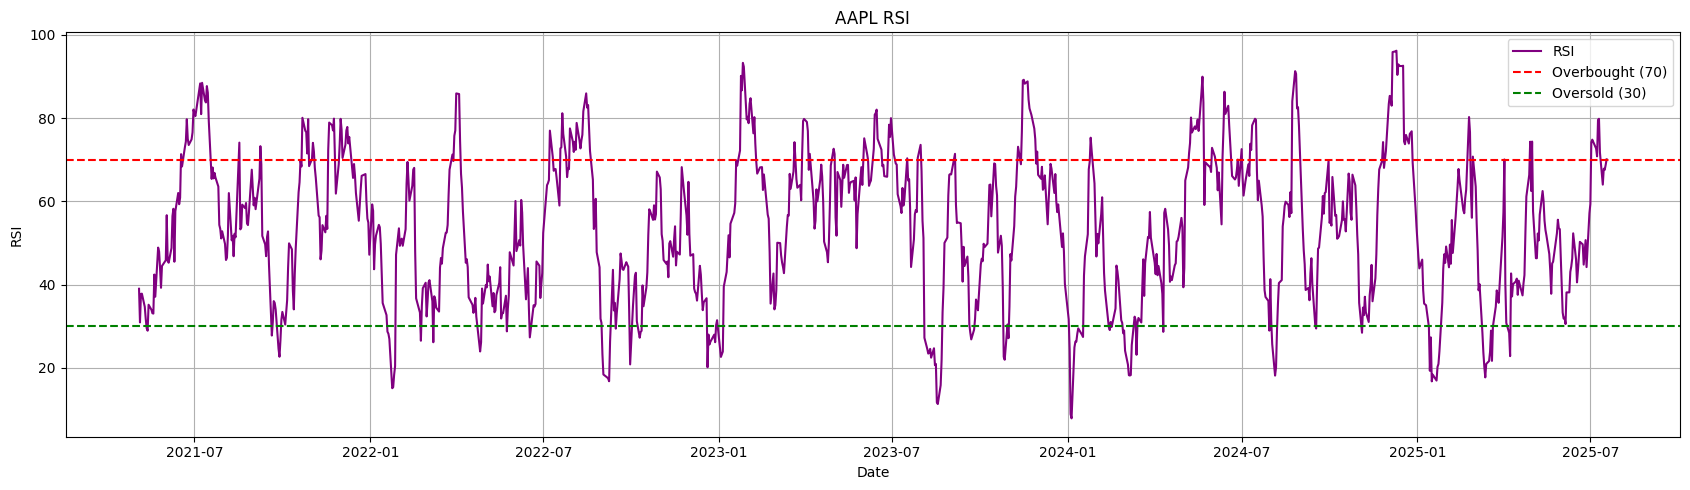

In [50]:
# Plot RSI

# fig = go.Figure()
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['RSI'], name = 'RSI', line = dict(color = 'purple')))
# fig.add_hline(y = 70, line_dash = 'dash', line_color = 'red', annotation_text = 'Overbought (70)')
# fig.add_hline(y = 30, line_dash = 'dash', line_color = 'green', annotation_text = 'Oversold (30)')
# fig.update_layout(title = f'{stock_ticker} RSI', xaxis_title = 'Date', yaxis_title = 'RSI', template = 'plotly_white')
# fig.show()

plt.figure(figsize = (17, 5))
plt.plot(stock_data.index, stock_data['RSI'], label = 'RSI', color = 'purple')
plt.axhline(y = 70, linestyle = '--', color = 'red', label = 'Overbought (70)')
plt.axhline(y = 30, linestyle = '--', color = 'green', label = 'Oversold (30)')

plt.title(f'{stock_ticker} RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* RSI values above 70 (red dashed line) suggest the stock might be overbought and due for a price drop.
* RSI below 30 (green dashed line) means the stock could be oversold and might bounce back. This helps traders understand momentum and potential reversals.

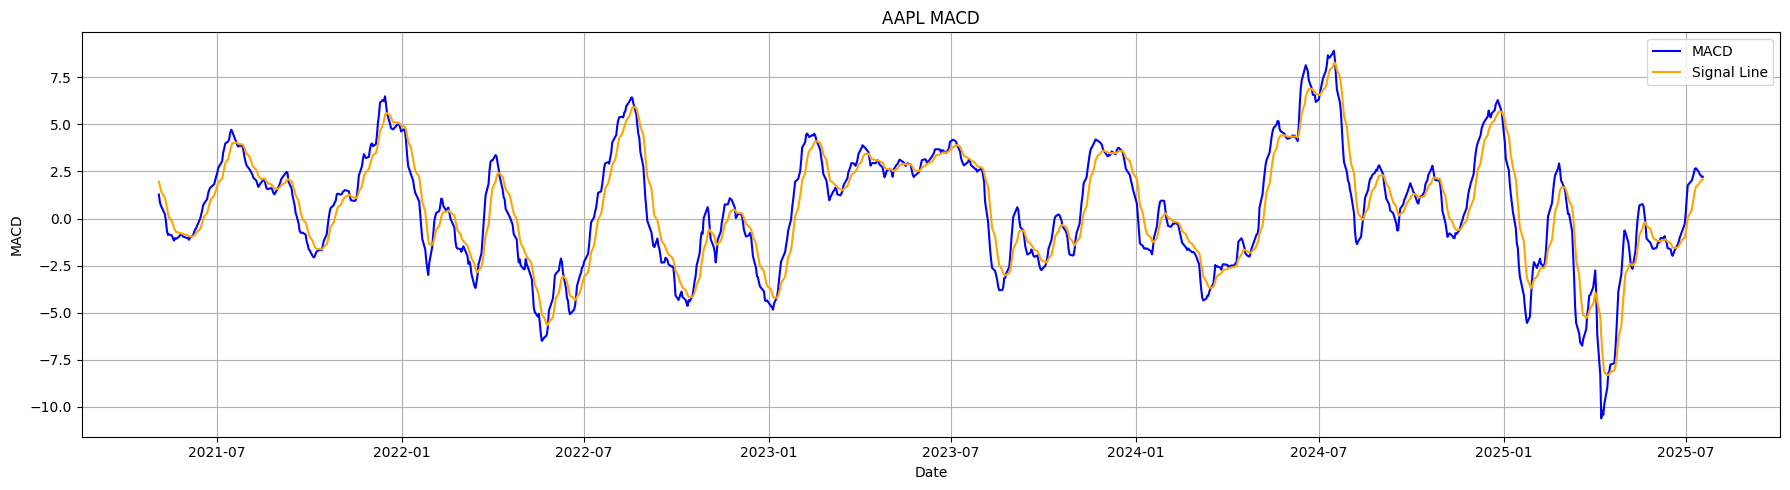

In [39]:
# Plot MCAD

# fig = go.Figure()
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['MACD'], name = 'MACD', line = dict(color = 'blue')))
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['MACD_Signal'], name = 'Signal Line', line = dict(color = 'orange')))
# fig.update_layout(title = f'{stock_ticker} MACD', xaxis_title = 'Date', yaxis_title = 'MACD', template = 'plotly_white')
# fig.show()

plt.figure(figsize = (18, 5))
plt.plot(stock_data.index, stock_data['MACD'], label = 'MACD', color = 'blue')
plt.plot(stock_data.index, stock_data['MACD_Signal'], label = 'Signal Line', color = 'orange')

plt.title(f'{stock_ticker} MACD')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* The MACD shows the difference between two moving averages (12-day and 26-day EMAs), which helps detect momentum changes.
* When the MACD crosses above the Signal line, it’s often a buy signal, crossing below can be a sell signal. This plot helps spot shifts in buying or selling pressure.

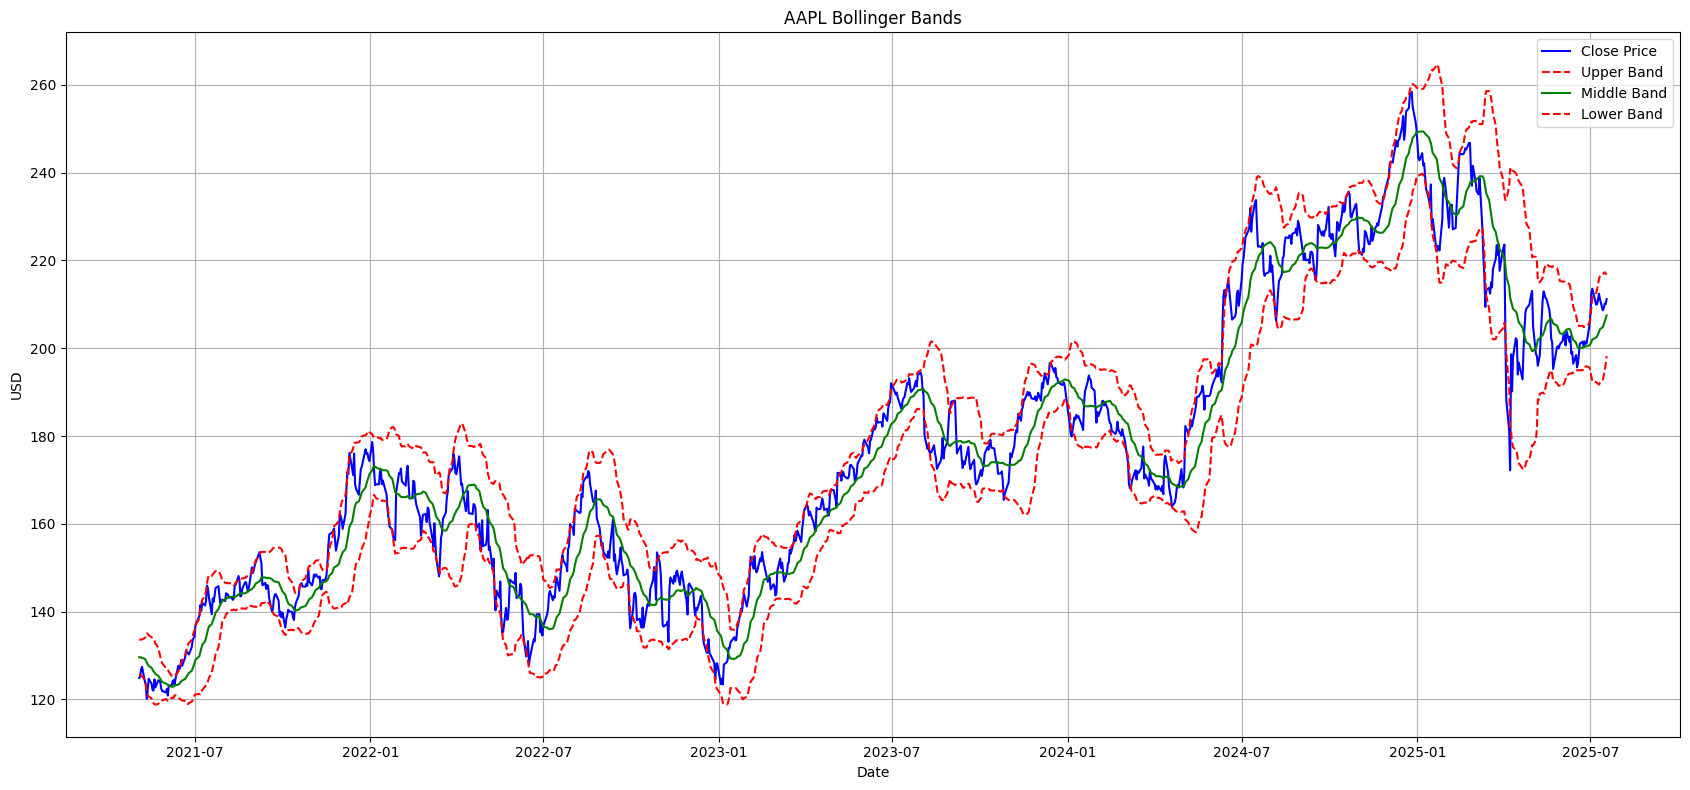

In [46]:
# Plot BB

# fig = go.Figure()
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['Close'], name = 'Close Price', line = dict(color = 'blue')))
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['BB_Upper'], name = 'Upper Band', line = dict(color = 'red', dash = 'dash')))
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['BB_Middle'], name = 'Middle Band', line = dict(color = 'green')))
# fig.add_trace(go.Scatter(x = stock_data.index, y = stock_data['BB_Lower'], name = 'Lower Band', line = dict(color = 'red', dash = 'dash')))
# fig.update_layout(title = f'{stock_ticker} Bollinger Bands', xaxis_title = 'Date', yaxis_title = '(USD)', template = 'plotly_white')
# fig.show()

plt.figure(figsize = (17, 8))
plt.plot(stock_data.index, stock_data['Close'], label = 'Close Price', color = 'blue')
plt.plot(stock_data.index, stock_data['BB_Upper'], label = 'Upper Band', color = 'red', linestyle = '--')
plt.plot(stock_data.index, stock_data['BB_Middle'], label = 'Middle Band', color = 'green')
plt.plot(stock_data.index, stock_data['BB_Lower'], label = 'Lower Band', color = 'red', linestyle = '--')

plt.title(f'{stock_ticker} Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* The bands widen or narrow based on volatility: wider means more price movement.
* When the price hits the upper band, it might be overbought; near the lower band, it might be oversold. Bollinger Bands help identify potential breakouts or reversals by showing how the price behaves relative to its recent average.

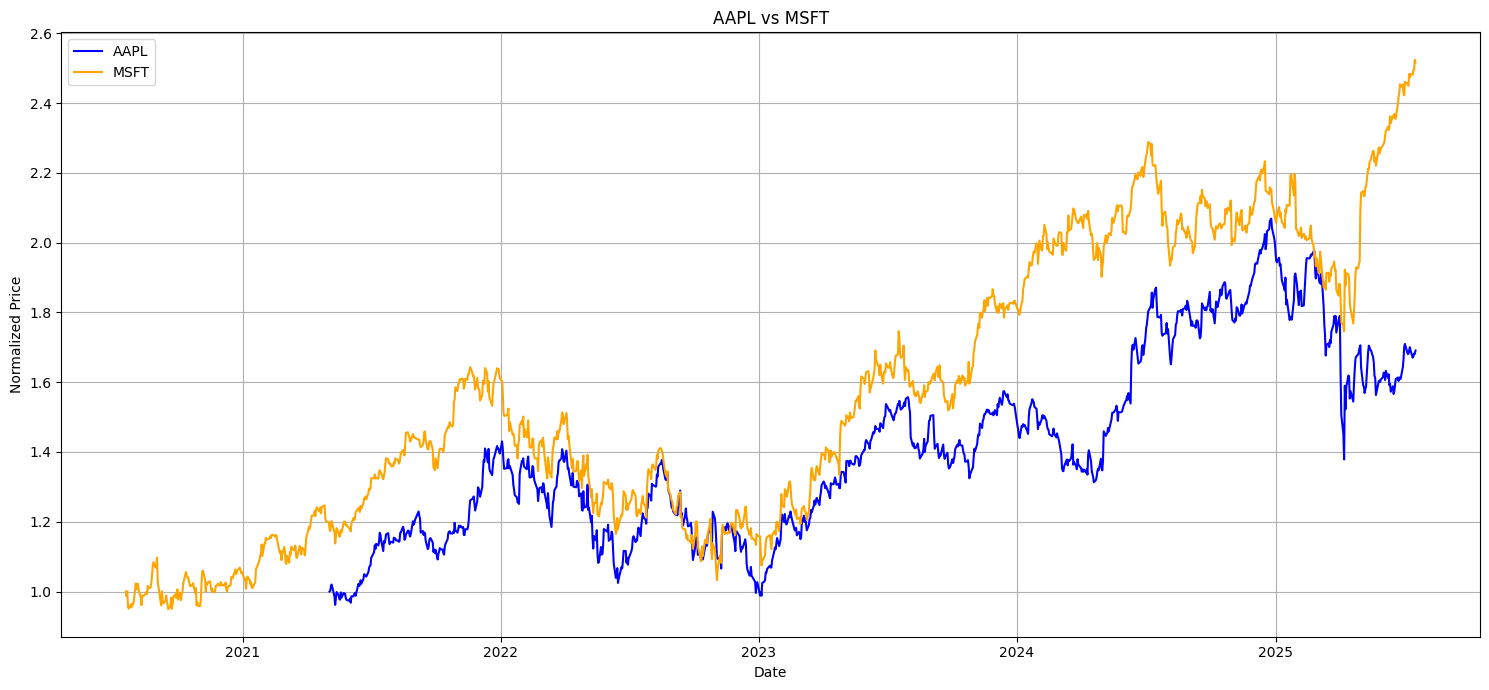

In [48]:
normalized_stock = stock_data['Close'] / stock_data['Close'].iloc[0]
normalized_comp = comp_data['Close'] / comp_data['Close'].iloc[0]


# fig = go.Figure()
# fig.add_trace(go.Scatter(x = stock_data.index, y = normalized_stock, name = stock_ticker, line = dict(color = 'blue')))
# fig.add_trace(go.Scatter(x = comp_data.index, y = normalized_comp, name = comp_ticker, line = dict(color = 'orange')))
# fig.update_layout(title=f'Normalized Price Comparison: {stock_ticker} vs {comp_ticker}', xaxis_title = 'Date', yaxis_title = 'Normalized Price', template = 'plotly_white')
# fig.show()

plt.figure(figsize = (15, 7))
plt.plot(stock_data.index, normalized_stock, label = stock_ticker, color = 'blue')
plt.plot(comp_data.index, normalized_comp, label = comp_ticker, color = 'orange')

plt.title(f'{stock_ticker} vs {comp_ticker}')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Firstly, it normalizes the closing prices of each stock by dividing all prices by the very first closing price. This sets the starting point to 1 for both stocks, making it easier to compare their relative growth regardless of their original price levels. Then, it creates a line chart with two lines: one for the normalized price of the first stock (blue) and one for the competitor stock (orange).

In [33]:
stock_data['Lagged Return'] = stock_data['Daily Return'].shift(1)
stock_data['Volume'] = stock_data['Volume'] / stock_data['Volume'].mean()
stock_data['RSI_Lagged'] = stock_data['RSI'].shift(1)
stock_data['MACD_Lagged'] = stock_data['MACD'].shift(1)
stock_data = stock_data.dropna()

# features and target

features = ['Lagged Return', 'Volume', 'RSI_Lagged', 'MACD_Lagged']

x = stock_data[features]
y = stock_data['Daily Return']

# Split data into train and test sets

train_size = int(len(x) * 0.8)

x_train, x_test = x[ : train_size], x[train_size : ]
y_train, y_test = y[ : train_size], y[train_size : ]

Mean Squared Error (MSE): 0.000413


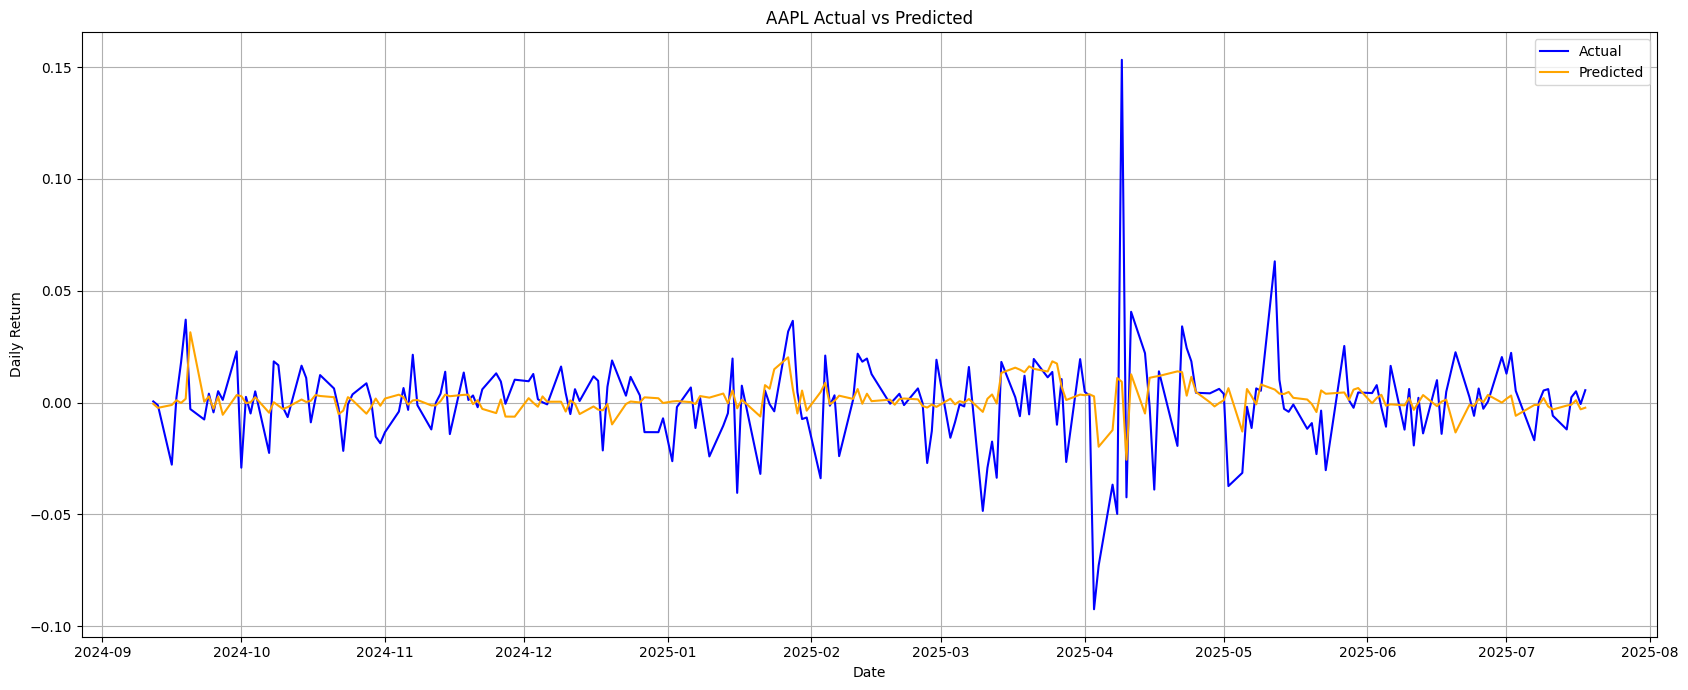

In [49]:
# Random Forest

try:
    model = RandomForestRegressor(n_estimators = 100, random_state = 0)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    # Evaluate

    mse = mean_squared_error(y_test, pred)
    print(f"Mean Squared Error (MSE): {mse:.6f}")

    # Plot

    # fig = go.Figure()
    # fig.add_trace(go.Scatter(x = y_test.index, y = y_test, name = 'Actual', line = dict(color = 'blue')))
    # fig.add_trace(go.Scatter(x = y_test.index, y = pred, name = 'Predicted', line = dict(color = 'orange')))
    # fig.update_layout(title = f'{stock_ticker} Actual vs Predicted', xaxis_title = 'Date', yaxis_title = 'Daily Return', template = 'plotly_white')
    # fig.show()

    plt.figure(figsize = (17, 7))
    plt.plot(y_test.index, y_test, label = 'Actual', color = 'blue')
    plt.plot(y_test.index, pred, label = 'Predicted', color = 'orange')

    plt.title(f'{stock_ticker} Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")
    raise

This code trains a Random Forest model to predict daily stock returns using training data. It then makes predictions on the test data and calculates the Mean Squared Error to measure accuracy. Finally, it plots actual vs predicted returns over time to visualize the model’s performance. Errors during this process are caught and displayed.

In [35]:
# Finally

***I WOULD LIKE TO EXPRESS MY SINCERE GRATITUDE FOR YOUR TIME AND CONSIDERATION***

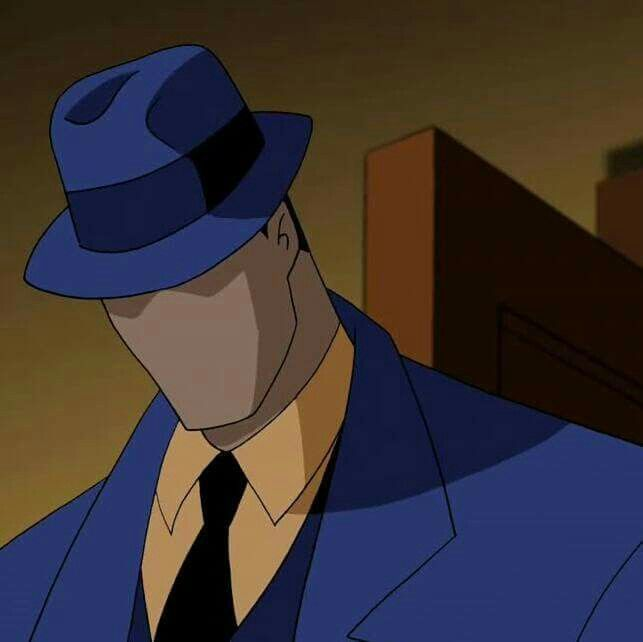